In [1]:
#import user modules
import helper_functions as hfun
import config as cf
import thouless_times as thouless
import importlib
importlib.reload(thouless)
importlib.reload(hfun)
importlib.reload(cf)
from os.path import exists

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.ticker import FormatStrFormatter
import os

#--- other modules
import numpy as np
import itertools
from scipy.signal import savgol_filter
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors

print(cf.base_directory)

../results/Heisenberg/symmetries/PBC/


## RESPONSE FUNCTION -- INTEGRABLE LIMIT

In [2]:
L = 14
w = 0.8
J=1.0
h=0.8
site = 1

def name_loc(L, w, site):
    return cf.base_directory + "ResponseFunction/j=%d/SigmaX_j=%d_L=%d,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(site, site, L, J, 0.0, 0.0, 0.0, h, w)

def name_ext(L, w):
    return cf.base_directory + "ResponseFunction/EXTENSIVE/SigmaX_L=%d,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(L, J, 0.0, 0.0, 0.0, h, w)

def name_sth(L, w):
    return cf.base_directory + "ResponseFunction/EXTENSIVE/smoothed/SigmaX_L=%d,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(L, J, 0.0, 0.0, 0.0, h, w)

def name_av(L, w):
    return cf.base_directory + "ResponseFunction/EXTENSIVE/SigmaXav_L=%d,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(L, J, 0.0, 0.0, 0.0, h, w)


def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

In [3]:
#fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(13,6), dpi = 100)
#
#def plot(axis, func = name_ext):
#    for Lx in range(11, 15):
#        if exists(func(Lx, w)):
#            spec_fun = np.array(np.loadtxt(func(Lx, w), unpack=True))
#            x = spec_fun[0]
#            y = spec_fun[1] * 2**Lx/np.sqrt(Lx)
#            p = axis.plot(x, y, label="L=%d"%(Lx))
#
#    #b=50.0; ax1.plot(x, 6.e-1 * x**2 * (np.log10(x/b))**2,ls='--', color='black', label=r"$\omega^2\cdot\left(log_{10}\ \frac{\omega}{%.2f}\right)^2$"%b)
#    #ax1.plot(x, 1.5e1 * np.exp(-5*(x-0.2)**2),ls='--', color='red', label=r"$const$")
#
#    axis.grid()
#    axis.legend()
#    axis.set_yscale('log')
#    axis.set_xscale('log')
#    axis.set_xlabel(r"$\omega$", rotation=0, fontsize=16, labelpad=10)
#    axis.set_ylabel(r"$\left\langle\left|\langle n|\sigma^x|m\rangle\right|^2\right\rangle \cdot \frac{D}{\sqrt{L}}$", fontsize=16, labelpad=10)
#    axis.set_ylim(1e0, 1e1)
#    axis.set_xlim(5e-4, 1e1)
#    #axis.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
#
#plot(axis=ax1, func=name_ext)
#plot(axis=ax2, func=name_sth)
#ax2.annotate('smoothed', xy=(100, 300), xycoords='axes points', color='black', size=20) 

# HYBRYDIZATION CONDITION -- DISORDERED CASES

### 'NON-DISORDERED' LIMIT -- HEISENBERG CHAIN

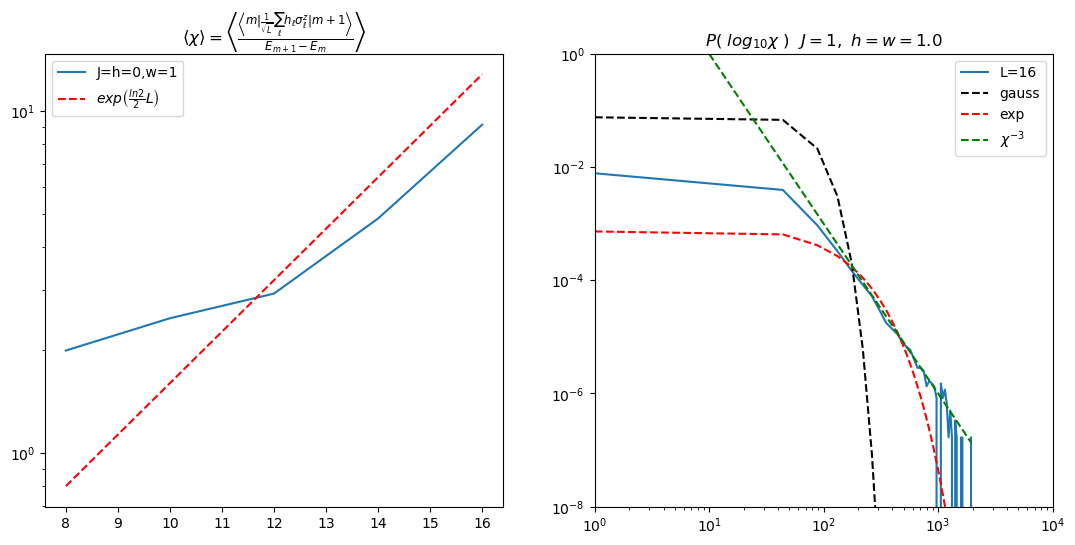

In [80]:
base_dir = "../results/Heisenberg/disorder/PBC/"
def name(J, h, w):
    return base_dir + "Hybrydization/Scaling_SigmaZ_disorder_w,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(J, 0.0, 0.55, 0.0, h, w)

def name_dist(L, J, h, w):
    return base_dir + "Hybrydization/Dist_SigmaZ_disorder_w_L=%d,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(L, J, 0.0, 0.55, 0.0, h, w)
    
fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(13,6), dpi = 100)
sth = np.array(np.loadtxt(name(1,0.0,0.05), unpack=True))
ax1.plot(sth[0], sth[2], label="J=h=0,w=1")
#ax1.plot(sth[0], 1e-3*np.exp(np.log(2) * sth[0]), ls='--', color='black', label=r"$exp\left(ln2\ L\right)$")
ax1.plot(sth[0], 0.05*np.exp(np.log(2)/2 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{2}L\right)$")
#sth = np.array(np.loadtxt(name(1,0.8,0.1), unpack=True))
#ax1.plot(sth[0], sth[1], label="J=1.0,h=w=0.8")
ax1.set_title(r"$\left\langle \chi\right\rangle=\left\langle\frac{\left\langle m\left|\frac{1}{\sqrt{L}}\sum_\ell h_\ell\sigma^z_\ell\right|m+1\right\rangle}{E_{m+1}-E_m}\right\rangle$")
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.legend()

#sth = np.array(np.loadtxt(name_dist(0,0.0,1.0), unpack=True))
#ax2.plot(sth[0], sth[1])
for L in range(16, 19, 2):
    name = name_dist(L, 1,0.0,0.05)
    if exists(name):
        sth = np.array(np.loadtxt(name, unpack=True))
        ax2.plot(sth[0], sth[1], label="L=%d"%L)

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def exponential(x, lam):
    return lam * np.exp(-lam*x);

ax2.plot(sth[0], 0.1*gaussian(sth[0], 0, 50), ls='--', color='black', label="gauss")
ax2.plot(sth[0], 0.1*exponential(sth[0], 0.01), ls='--', color='red', label="exp")
ax2.plot(sth[0], 1e3*sth[0]**(-3), ls='--', color='green', label=r"$\chi^{-3}$")
ax2.legend()
ax2.set_title(r"$P\left(\ log_{10}\chi\ \right)\ \ J=1,\ h=w=1.0$")
ax2.set_yscale('log')
ax2.set_ylim(1e-8,1)
ax2.set_xlim(1,1e4)
ax2.set_xscale('log')

### NON-INTERACTING LIMIT -- ANDERSON MODEL

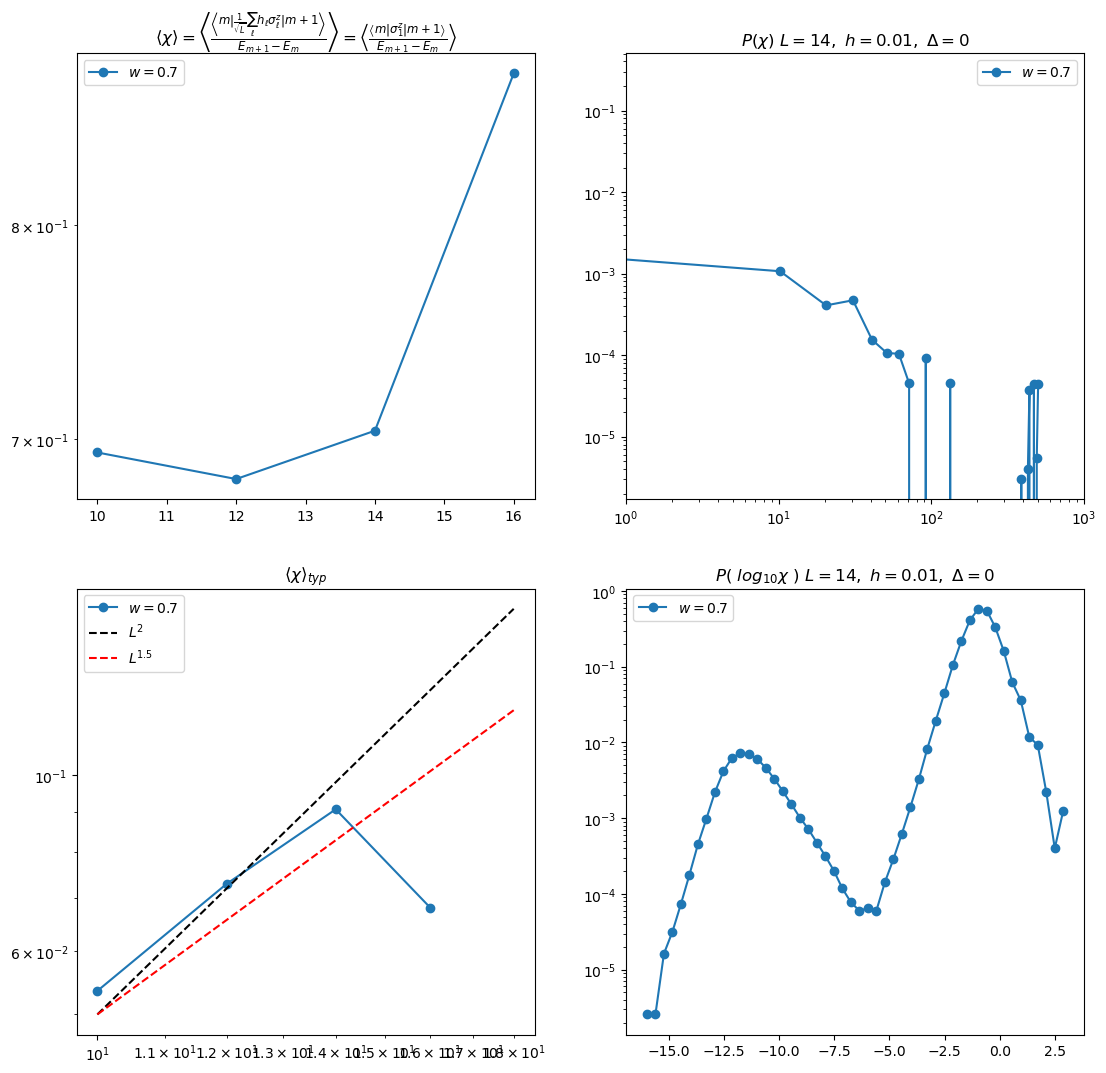

In [115]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def exponential(x, lam):
    return lam * np.exp(-lam*x);

LOGSCALE=1

base_dir = "../results/Heisenberg/disorder/PBC/"
def name(w):
    return base_dir + "Hybrydization/Scaling_SigmaZ_nn_delta,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(1.0, 0.0, 0.0, 0.0, 0.0, w)

def name_dist(L, w):
    return base_dir + "Hybrydization/Dist_SigmaZ_nn_delta" + ("_log" if LOGSCALE else "") + "_L=%d,J=%.2f,J0=%.2f,g=%.2f,g0=%.2f,h=%.2f,w=%.2f.dat"%(L, 1.0, 0.0, 0.0, 0.0, 0.0, w)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(13,13), dpi = 100)
sth = np.array(np.loadtxt(name(0.7), unpack=True));     ax1.plot(sth[0], sth[1], marker='o', label=r"$w=0.7$")
#sth = np.array(np.loadtxt(name(1.6), unpack=True));     ax1.plot(sth[0], sth[1], marker='o', label=r"$w=1.6$")
#ax1.plot(sth[0], 0.08*np.exp(np.log(2)/2 * sth[0]), ls='--', color='black', label=r"$exp\left(\frac{ln2}{2}L\right)$")
#ax1.plot(sth[0], 0.5*np.exp(np.log(2)/4 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{4}L\right)$")

ax1.set_title(r"$\left\langle \chi\right\rangle=\left\langle\frac{\left\langle m\left|\frac{1}{\sqrt{L}}\sum_\ell h_\ell\sigma^z_\ell\right|m+1\right\rangle}{E_{m+1}-E_m}\right\rangle=\left\langle\frac{\left\langle m\left|\sigma^z_1\right|m+1\right\rangle}{E_{m+1}-E_m}\right\rangle$")
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.legend()

LOGSCALE=0

sth = np.array(np.loadtxt(name_dist(16, 0.7), unpack=True));      ax2.plot(sth[0], sth[1], marker='o', label=r"$w=0.7$")
#sth = np.array(np.loadtxt(name_dist(14, 1.6), unpack=True));      ax2.plot(sth[0], sth[1], marker='o', label=r"$w=1.6$")
#ax2.set_xlim(1e-1,1e3)
if LOGSCALE == 0: ax2.set_xscale('log')

ax2.legend()
ax2.set_title(r"$P\left(\chi\right)\ L=14,\ h=0.01,\ \Delta=0$")
ax2.set_yscale('log')
#ax2.set_ylim(1e-8,1)
ax2.set_xlim(1e0,1e3)
if LOGSCALE == 0:
     ax2.set_xscale('log')

sth = np.array(np.loadtxt(name(0.7), unpack=True)); ax3.plot(sth[0], sth[2], marker='o', label=r"$w=0.7$")
#sth = np.array(np.loadtxt(name(1.6), unpack=True)); ax3.plot(sth[0], sth[2], marker='o', label=r"$w=1.6$")

ax3.plot(sth[0], 0.05*(sth[0]/10)**2, ls='--', color='black', label=r"$L^2$")
ax3.plot(sth[0], 0.05*(sth[0]/10)**1.5, ls='--', color='red', label=r"$L^{1.5}$")
ax3.set_title(r"$\left\langle \chi\right\rangle_{typ}$")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()

LOGSCALE=1
sth = np.array(np.loadtxt(name_dist(16, 0.7), unpack=True));     ax4.plot(sth[0], sth[1], marker='o', label=r"$w=0.7$")
#sth = np.array(np.loadtxt(name_dist(14, 1.6), unpack=True));     ax4.plot(sth[0], sth[1], marker='o', label=r"$w=1.6$")

ax4.set_title(r"$P\left(\ log_{10}\chi\ \right)\ L=14,\ h=0.01,\ \Delta=0$")
ax4.legend()
ax4.set_yscale('log')

# HYBRYDIZATION CONDITION -- SYMMETRIC CASES

### 'NON-DISORDERED' LIMIT -- HEISENBERG CHAIN

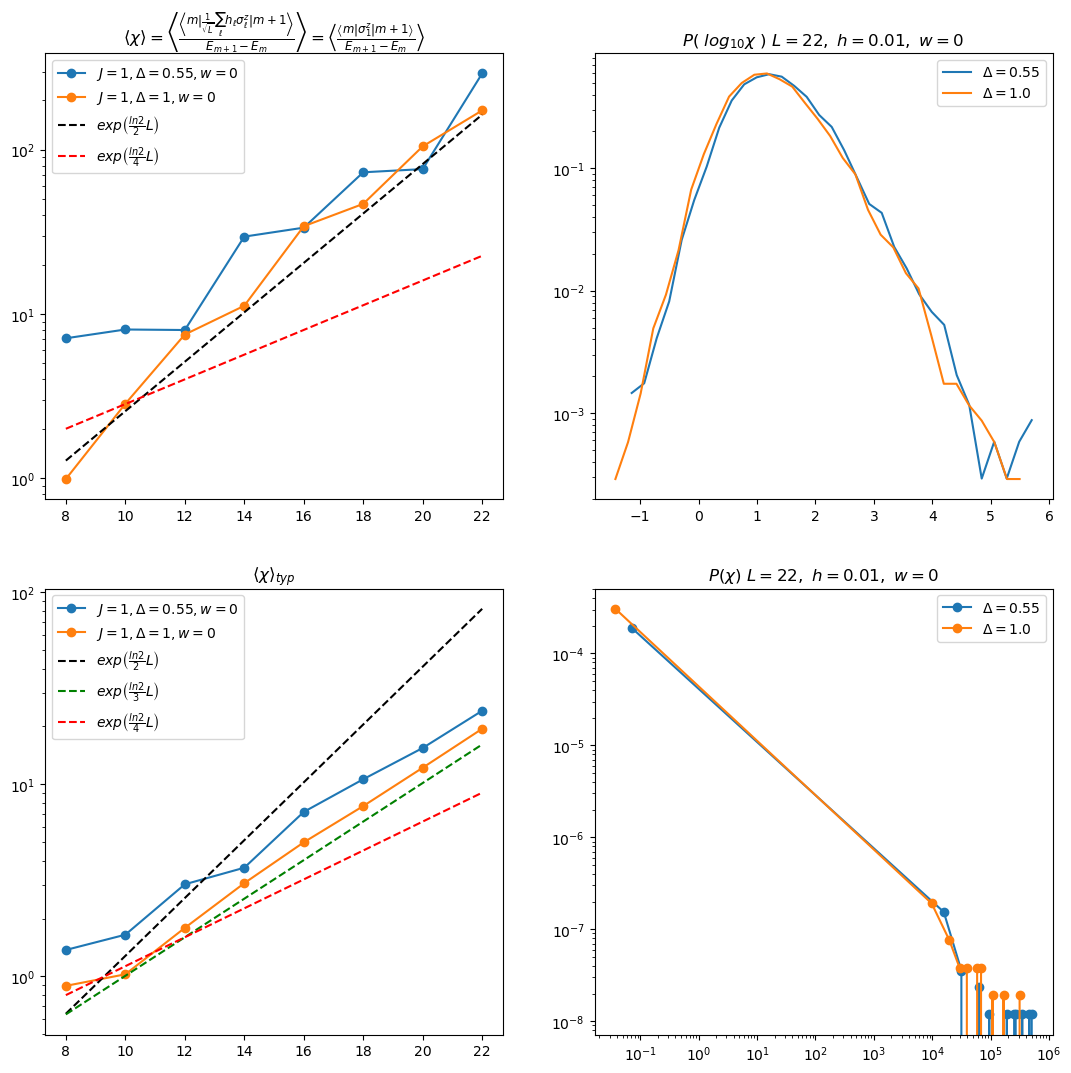

In [6]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def exponential(x, lam):
    return lam * np.exp(-lam*x);

LOGSCALE=1

base_dir = "../results/Heisenberg/symmetries/PBC/"
def name(J, g, h, choose=1):
    opname =  "SigmaZ_disorder" if choose else "SigmaZ_j=1"
    return base_dir+ "Hybrydization/Scaling_" + opname + "_w,J=%.2f,g=%.2f,h=%.2f,k=1,p=1,x=-1.dat"%(J, g, h)

def name_dist(L, J, g, h, choose=1):
    opname =  "SigmaZ_disorder" if choose else "SigmaZ_j=1"
    return base_dir + "Hybrydization/Dist_" + opname + "_w" + ("_log" if LOGSCALE else "") + "_L=%d,J=%.2f,g=%.2f,h=%.2f,k=1,p=1,x=-1.dat"%(L, J, g, h)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(13,13), dpi = 100)
sth = np.array(np.loadtxt(name(1, 0.55, 0.01, 0), unpack=True)); ax1.plot(sth[0], sth[1], marker='o', label=r"$J=1,\Delta=0.55,w=0$")
sth = np.array(np.loadtxt(name(1, 1.00, 0.01, 0), unpack=True)); ax1.plot(sth[0], sth[1], marker='o', label=r"$J=1,\Delta=1,w=0$")
ax1.plot(sth[0], 0.08*np.exp(np.log(2)/2 * sth[0]), ls='--', color='black', label=r"$exp\left(\frac{ln2}{2}L\right)$")
ax1.plot(sth[0], 0.5*np.exp(np.log(2)/4 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{4}L\right)$")

ax1.set_title(r"$\left\langle \chi\right\rangle=\left\langle\frac{\left\langle m\left|\frac{1}{\sqrt{L}}\sum_\ell h_\ell\sigma^z_\ell\right|m+1\right\rangle}{E_{m+1}-E_m}\right\rangle=\left\langle\frac{\left\langle m\left|\sigma^z_1\right|m+1\right\rangle}{E_{m+1}-E_m}\right\rangle$")
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.legend()

sth = np.array(np.loadtxt(name_dist(22, 1, 0.55, 0.01, 0), unpack=True));      ax2.plot(sth[0], sth[1], label=r"$\Delta=0.55$")
sth = np.array(np.loadtxt(name_dist(22, 1, 1.0, 0.01, 0), unpack=True));      ax2.plot(sth[0], sth[1], label=r"$\Delta=1.0$")

ax2.legend()
ax2.set_title(r"$P\left(\ log_{10}\chi\ \right)\ L=22,\ h=0.01,\ w=0$")
ax2.set_yscale('log')
#ax2.set_ylim(1e-8,1)
#ax2.set_xlim(1,1e4)
if LOGSCALE == 0:
     ax2.set_xscale('log')

sth = np.array(np.loadtxt(name(1, 0.55, 0.01, 0), unpack=True)); ax3.plot(sth[0], sth[2], marker='o', label=r"$J=1,\Delta=0.55,w=0$")
sth = np.array(np.loadtxt(name(1, 1.00, 0.01, 0), unpack=True)); ax3.plot(sth[0], sth[2], marker='o', label=r"$J=1,\Delta=1,w=0$")

ax3.plot(sth[0], 0.04*np.exp(np.log(2)/2 * sth[0]), ls='--', color='black', label=r"$exp\left(\frac{ln2}{2}L\right)$")
ax3.plot(sth[0], 0.1*np.exp(np.log(2)/3 * sth[0]), ls='--', color='green', label=r"$exp\left(\frac{ln2}{3}L\right)$")
ax3.plot(sth[0], 0.2*np.exp(np.log(2)/4 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{4}L\right)$")
ax3.set_title(r"$\left\langle \chi\right\rangle_{typ}$")
ax3.set_yscale('log')
#ax1.set_xscale('log')
ax3.legend()

LOGSCALE=0
sth = np.array(np.loadtxt(name_dist(22, 1, 0.55, 0.01, 0), unpack=True));     ax4.plot(sth[0], sth[1], marker='o', label=r"$\Delta=0.55$")
sth = np.array(np.loadtxt(name_dist(22, 1, 1.0, 0.01, 0), unpack=True));      ax4.plot(sth[0], sth[1], marker='o', label=r"$\Delta=1.0$")

ax4.legend()
ax4.set_title(r"$P\left(\chi\right)\ L=22,\ h=0.01,\ w=0$")
ax4.set_yscale('log')
if LOGSCALE == 0: ax4.set_xscale('log')

### NON-INTERACTING LIMIT -- ANDERSON MODEL

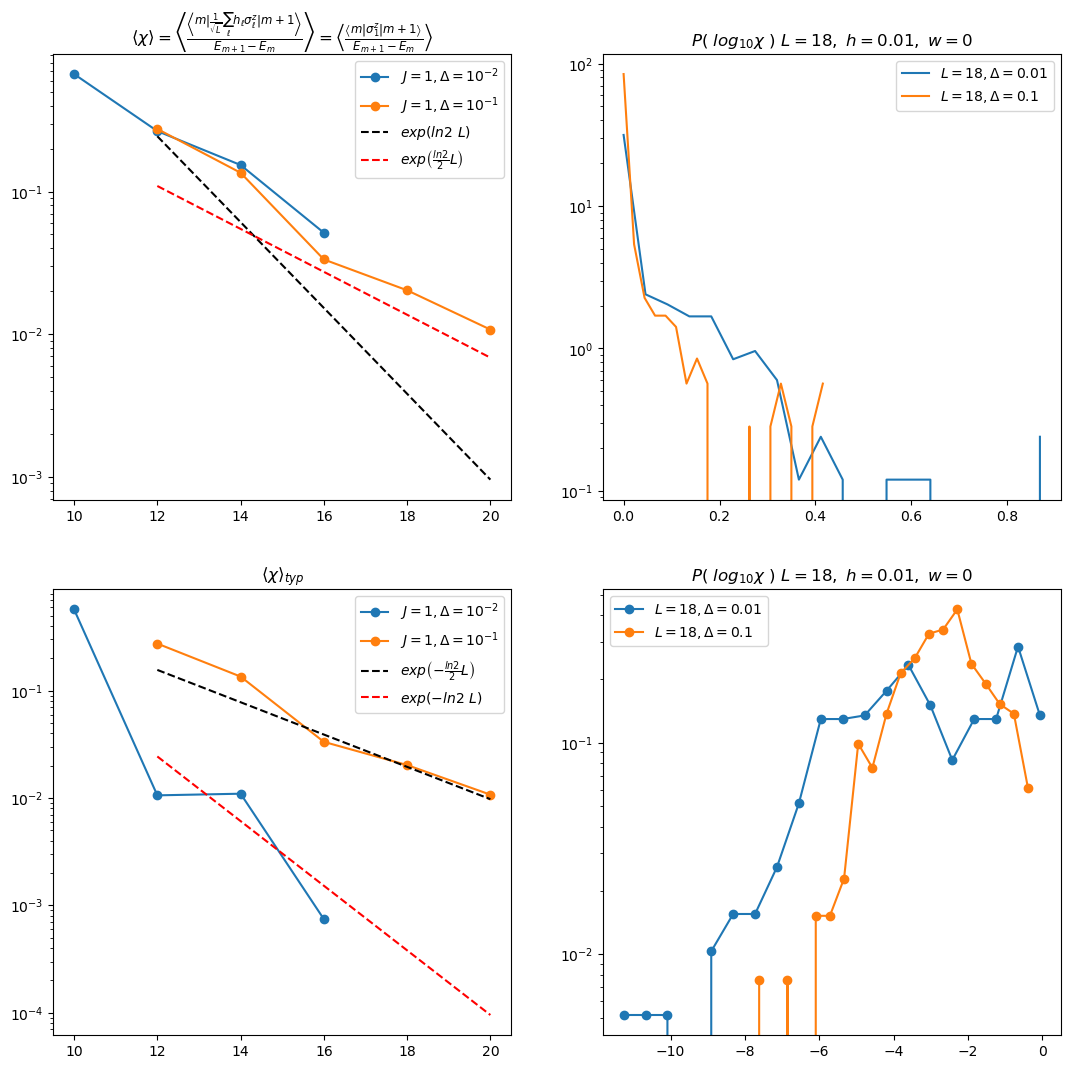

In [120]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def exponential(x, lam):
    return lam * np.exp(-lam*x);

LOGSCALE=1
state_100_av=0
average_sym_sectors=0
k_sector=-1
suffix = "" if average_sym_sectors else ",k=%d,p=1,x=1"%k_sector 
opname = "SigmaZ_nn" + ("_av" if state_100_av else "")
base_dir = "../results/Heisenberg/symmetries/PBC/"
def name(delta=0.01):
    return base_dir+ "Hybrydization/Scaling_" + opname + "_delta,J=%.2f,g=%.2f,h=%.2f"%(1.0, delta, 0.0) + suffix + ".dat"

def name_dist(L, delta=0.01):
    return base_dir + "Hybrydization/Dist_" + opname + "_delta" + ("_log" if LOGSCALE else "") + "_L=%d,J=%.2f,g=%.2f,h=%.2f"%(L, 1.0, delta, 0.0) + suffix + ".dat"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(13,13), dpi = 100)
#sth = np.array(np.loadtxt(name(0.001), unpack=True));           ax1.plot(sth[0], sth[1], marker='o', label=r"$J=1,\Delta=10^{-3}$")
sth = np.array(np.loadtxt(name(), unpack=True));                ax1.plot(sth[0], sth[1], marker='o', label=r"$J=1,\Delta=10^{-2}$")
sth = np.array(np.loadtxt(name(0.1), unpack=True));             ax1.plot(sth[0], sth[1], marker='o', label=r"$J=1,\Delta=10^{-1}$")
ax1.plot(sth[0], 1e3*np.exp(-np.log(2) * sth[0]), ls='--', color='black', label=r"$exp\left(ln2\ L\right)$")
ax1.plot(sth[0], 0.7e1*np.exp(-np.log(2)/2 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{2}L\right)$")
#ax1.plot(sth[0], 0.04*np.exp(np.log(2)/2 * sth[0]), ls='--', color='black', label=r"$exp\left(\frac{ln2}{2}L\right)$")
#ax1.plot(sth[0], 0.2*np.exp(np.log(2)/3 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{3}\ L\right)$")

ax1.set_title(r"$\left\langle \chi\right\rangle=\left\langle\frac{\left\langle m\left|\frac{1}{\sqrt{L}}\sum_\ell h_\ell\sigma^z_\ell\right|m+1\right\rangle}{E_{m+1}-E_m}\right\rangle=\left\langle\frac{\left\langle m\left|\sigma^z_1\right|m+1\right\rangle}{E_{m+1}-E_m}\right\rangle$")
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.legend()

ax2.set_title(r"$P\left(\chi\right)\ L=22,\ h=0.0,\ w=0$")
LOGSCALE=0
#for L in range(12, 22, 2):
sth = np.array(np.loadtxt(name_dist(18, 0.01), unpack=True));      ax2.plot(sth[0], sth[1], label=r"$L=%d,\Delta=0.01$"%L)
sth = np.array(np.loadtxt(name_dist(18, 0.1), unpack=True));       ax2.plot(sth[0], sth[1], label=r"$L=%d,\Delta=0.1$"%L)

ax2.legend()
ax2.set_title(r"$P\left(\ log_{10}\chi\ \right)\ L=18,\ h=0.01,\ w=0$")
ax2.set_yscale('log')
#ax2.set_ylim(1e-8,1)
#ax2.set_xlim(1,1e4)
#if LOGSCALE == 0: ax2.set_xscale('log')

#sth = np.array(np.loadtxt(name(0.001), unpack=True));        ax3.plot(sth[0], sth[2], marker='o', label=r"$J=1,\Delta=10^{-3}$")
sth = np.array(np.loadtxt(name(0.01), unpack=True));        ax3.plot(sth[0], sth[2], marker='o', label=r"$J=1,\Delta=10^{-2}$")
sth = np.array(np.loadtxt(name(0.1), unpack=True));     ax3.plot(sth[0], sth[1], marker='o', label=r"$J=1,\Delta=10^{-1}$")
ax3.plot(sth[0], 10*np.exp(-np.log(2)/2 * sth[0]), ls='--', color='black', label=r"$exp\left(-\frac{ln2}{2}L\right)$")
ax3.plot(sth[0], 100*np.exp(-np.log(2) * sth[0]), ls='--', color='red', label=r"$exp\left(-ln2\ L\right)$")

#
#ax3.plot(sth[0], 0.04*np.exp(np.log(2)/2 * sth[0]), ls='--', color='black', label=r"$exp\left(\frac{ln2}{2}L\right)$")
#ax3.plot(sth[0], 0.15*np.exp(np.log(2)/3 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{3}\ L\right)$")
##ax3.plot(sth[0], 0.05*np.exp(np.log(2)/2 * sth[0]), ls='--', color='red', label=r"$exp\left(\frac{ln2}{2}L\right)$")
ax3.set_title(r"$\left\langle \chi\right\rangle_{typ}$")
ax3.set_yscale('log')
#ax1.set_xscale('log')
ax3.legend()

LOGSCALE=1
#for L in range(12, 22, 2):
sth = np.array(np.loadtxt(name_dist(18, 0.01), unpack=True));      ax4.plot(sth[0], sth[1], marker='o', label=r"$L=%d,\Delta=0.01$"%L)
sth = np.array(np.loadtxt(name_dist(18, 0.1), unpack=True));       ax4.plot(sth[0], sth[1], marker='o', label=r"$L=%d,\Delta=0.1$"%L)

ax4.legend()
ax4.set_title(r"$P\left(\ log_{10}\chi\ \right)\ L=18,\ h=0.01,\ w=0$")
ax4.set_yscale('log')
if LOGSCALE == 0: ax4.set_xscale('log')